In [1]:
import sys
import os
from time import time

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from skimage import measure
from scipy.optimize import linear_sum_assignment

sys.path.insert(0, os.path.abspath('..'))

from src.utils.load_cfg import ConfigLoader
from src.factories import ModelFactory
from src.factories import DatasetFactory
from src.utils.misc import MiscUtils
from src.models.pytorch_ssim.ssim import SSIM

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid', {'axes.grid': False})

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_cfg = '../configs/dataset_cfgs/epickitchens_short.yaml'
train_cfg = '../configs/train_cfgs/train_san_freeze_short.yaml'
model_cfg = '../configs/model_cfgs/pipeline5_rgbspec_san19pairfreeze_actreggru3_top3_cat.yaml'

In [14]:
#--------------------------------------------------------------------------------------
# Load configurations
model_name, model_params = ConfigLoader.load_model_cfg(model_cfg)
dataset_name, dataset_params = ConfigLoader.load_dataset_cfg(dataset_cfg)
train_params = ConfigLoader.load_train_cfg(train_cfg)

dataset_params.update({
    'modality': model_params['modality'],
    'num_segments': model_params['num_segments'],
    'new_length': model_params['new_length'],
})

for k in ['low_feat_model_cfg', 'high_feat_model_cfg', 'actreg_model_cfg', 'spatial_sampler_cfg']:
    model_params[k] = '../'+model_params[k]

#--------------------------------------------------------------------------------------
# Build model
model_factory = ModelFactory()
model = model_factory.generate(model_name, device=device, model_factory=model_factory, **model_params)
model = model.to(device)
# model.load_model(model_weight)
model.eval()

#--------------------------------------------------------------------------------------
# Get training augmentation and transforms
train_augmentation = MiscUtils.get_train_augmentation(model.modality, model.crop_size)
train_transform, val_transform = MiscUtils.get_train_val_transforms(
    modality=model.modality,
    input_mean=model.input_mean,
    input_std=model.input_std,
    scale_size=model.scale_size,
    crop_size=model.crop_size,
    train_augmentation=train_augmentation,
)

#--------------------------------------------------------------------------------------
# Data loader
dataset_factory = DatasetFactory()
loader_params = {
    'batch_size': train_params['batch_size'],
    'num_workers': train_params['num_workers'],
    'pin_memory': True,
}

val_dataset = dataset_factory.generate(dataset_name, mode='val', transform=val_transform, **dataset_params)
val_loader = DataLoader(val_dataset, shuffle=False, **loader_params)

In [15]:
def experiment(sample_id, spatial_sampler, **opts):
    with torch.no_grad():
        # Get a sample
        sample, _ = val_loader.dataset[sample_id]
        sample = {k: v.unsqueeze(dim=0).to(device) for k, v in sample.items()}

        # Forward
        model(sample)

        # Extract intermediate data, replicate the sampling process
        attn = model._pivot_mod_fn.get_attention_weight(
            l_name=model.attention_layer[0],
            m_name=model.attention_layer[1],
            aggregated=True,
        )

        bboxes = spatial_sampler.sample_multiple_frames(
            attn.unsqueeze(dim=0), sample['RGB'].shape[-1], **opts)

    rgb = MiscUtils.deprocess_rgb(sample['RGB'][0], model.num_segments)
    fig, axes = plt.subplots(3+spatial_sampler.top_k, model.num_segments, figsize=(20, 10))
    vmin = attn.mean(dim=1).min().item()
    vmax = attn.mean(dim=1).max().item()
    for t in range(model.num_segments):
        axes[0, t].imshow(rgb[t])
        axes[1, t].imshow(attn[t].mean(dim=0).cpu().detach().numpy(), vmin=vmin, vmax=vmax)
        marked = np.copy(rgb[t])
        for k in range(spatial_sampler.top_k):
            top, left, bottom, right = bboxes[0, t, k]
            marked[top:bottom, left:right, k] = 255
        axes[2, t].imshow(marked)

        for k in range(spatial_sampler.top_k):
            cropped = np.zeros_like(rgb[t])+255
            top, left, bottom, right = bboxes[0, t, k]
            cropped[top:bottom, left:right] = rgb[t, top:bottom, left:right]
            axes[3+k, t].imshow(cropped)
            axes[3+k, 0].set_ylabel('top_{}'.format(k+1))
    for ax in axes.ravel():
        ax.set_xticks([])
        ax.set_yticks([])
    return bboxes, rgb

<hr style="height:30px; background-color:#123456;"/>

## Default settings

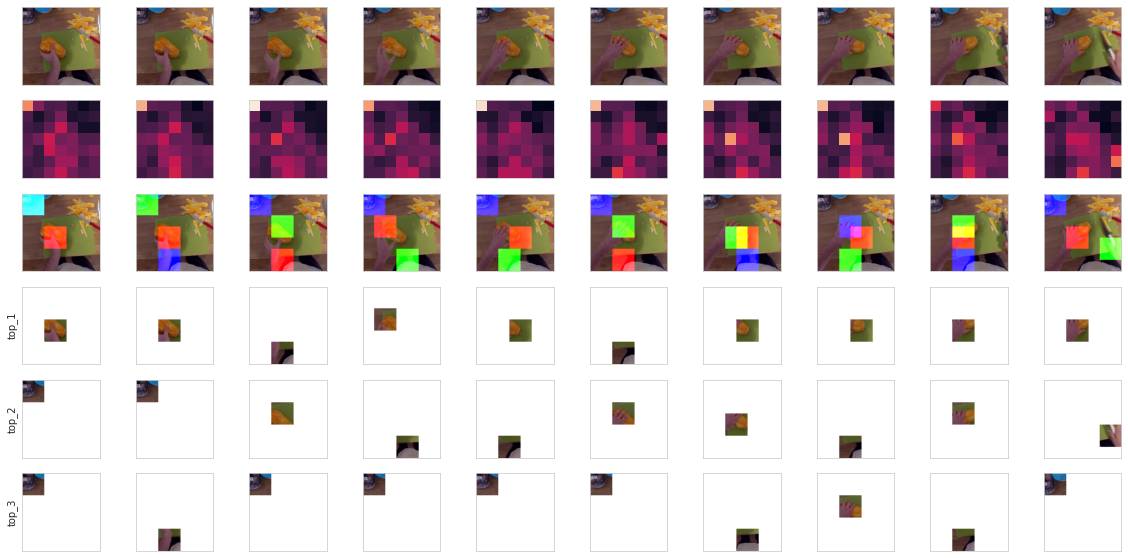

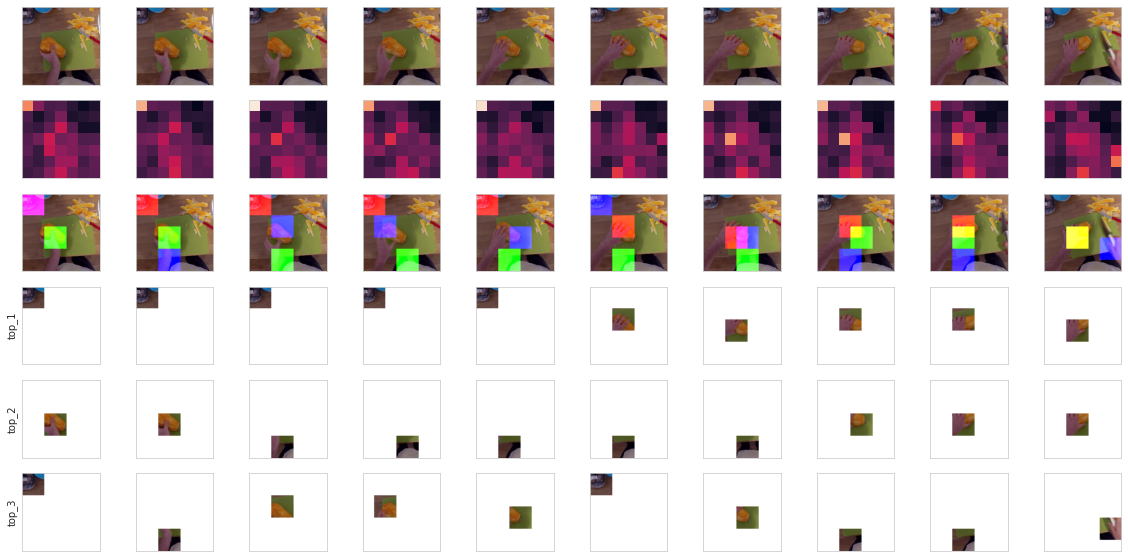

In [18]:
sample_id = 66  # --> good example
# sample_id = 17
# sample_id = 57  # --> duplicated regions

spatial_sampler = model.spatial_sampler  # Default sampler

# opts = {'reorder_vid':False, 'reorder_pair':True, 'avg_across_time':True}
# bboxes, rgb = experiment(sample_id, spatial_sampler, **opts)

opts = {'reorder_vid':False, 'reorder_pair':False, 'avg_across_time':False}
bboxes, rgb = experiment(sample_id, spatial_sampler, **opts)

opts = {'reorder_vid':True, 'reorder_pair':False, 'avg_across_time':True}
bboxes, rgb = experiment(sample_id, spatial_sampler, **opts)

In [5]:
class Graph:
    def __init__(self, bboxes, visited):
        T = bboxes.shape[0]
        K = bboxes.shape[1]
        self.top_k = K
        self.n_vertices = T*K
        self.graph = np.zeros([self.n_vertices, self.n_vertices])
        
        # Make graph from bbox
        for t in range(T-1):
            frame_1 = bboxes[t]
            frame_2 = bboxes[t+1]
            for k1 in range(K):
                if visited[t, k1]:
                    continue
                t1, l1, b1, r1 = frame_1[k1]
                    
                for k2 in range(K):
                    if visited[t, k2]:
                        continue
                    t2, l2, b2, r2 = frame_2[k2]
                    
                    # trellis to vertex index
                    v1 = t*K + k1
                    v2 = (t+1)*K + k2
                    
                    # compute score
                    area1 = (b1-t1)*(r1-l1)
                    area2 = (b2-t2)*(r2-l2)
                    self.graph[v1, v2] = max( ((frame_1[k1]-frame_2[k2])**2).sum(), 0.1) \
                                         + abs(area1-area2)
                    #x1, y1 = (frame_1[k1][0]+frame_1[k1][2])/2, (frame_1[k1][1]+frame_1[k1][3])/2
                    #x2, y2 = (frame_2[k2][0]+frame_2[k2][2])/2, (frame_2[k2][1]+frame_2[k2][3])/2
                    #self.graph[v1, v2] = (x1-x2)**2 + (y1-y2)**2
                    
    def get_min_index(self, dist, visited):
        min_dst = sys.maxsize
        min_index = None
        
        for v in range(self.n_vertices):
            if dist[v] < min_dst and not visited[v]:
                min_dst = dist[v]
                min_index = v
        return min_index
                    
    def dijkstra(self, src):
        dist = [sys.maxsize for _ in range(self.n_vertices)]
        dist[src] = 0
        visited = [False for _ in range(self.n_vertices)]
        prev = [None for _ in range(self.n_vertices)]

        for _ in range(self.n_vertices):
            u = self.get_min_index(dist, visited)
            if u is None:
                continue
                
            visited[u] = True
            for v in range(self.n_vertices):
                alt_dst = dist[u] + self.graph[u][v]
                if (self.graph[u, v] > 0) and (not visited[v]) and (dist[v] > alt_dst):
                    dist[v] = alt_dst
                    prev[v] = u
        return dist, prev
    
    def get_path(self, prev, src, target):
        path = []
        u = target
        while prev[u] is not None:
            path.append(u)
            u = prev[u]
        path.append(src)
        return [x%self.top_k for x in path[::-1]]

def reorder_dijkstra(bboxes, rgb):
    import time
    st = time.time()
    T, K, _ = bboxes.shape
    visited = np.zeros([T, K], dtype=bool)
    orders = []
    
    # ============================================
    import time
    for _ in range(K-1):
        graph = Graph(bboxes, visited)
        min_dist, min_prev, min_pair = sys.maxsize, None, None
        
        # Run dijkstra for each bbox of the first frame
        for src in range(K):
            dist, prev = graph.dijkstra(src)
            
            # Find the min path to the bboxes of the last frame
            for target in range(graph.n_vertices-K, graph.n_vertices):
                if min_dist > dist[target]:
                    min_dist = dist[target]
                    min_prev = prev
                    min_pair = (src, target)
                    
        # Retrieve the path with the lowest cost first
        path = graph.get_path(min_prev, min_pair[0], min_pair[1])
        orders.append(path)

        # Mark the path as visited to ignore
        for t in range(T):
            visited[t, path[t]] = True

    # The last remaining path
    path = [np.argmin(x) for x in visited]
    orders.append(path)
    print(time.time()-st)
    
    # Swap the bboxes based on the new order
    orders = np.stack(orders).T
    new_bboxes = np.array([bboxes[t][orders[t]] for t in range(T)])

    # ============================================
    fig, axes = plt.subplots(2, T, figsize=(20, 4))
    for t in range(T):
        # default
        tmp = np.copy(rgb[t])
        for k in range(3):
            top, left, bottom, right = bboxes[t, k]
            tmp[top:bottom, left:right, k] = 255
        axes[0, t].imshow(tmp)
        axes[0, t].set_xticks([])
        axes[0, t].set_yticks([])

        # dijkstra
        tmp = np.copy(rgb[t])
        for k in range(3):
            top, left, bottom, right = new_bboxes[t, k]
            tmp[top:bottom, left:right, k] = 255
        axes[1, t].imshow(tmp)
        axes[1, t].set_xticks([])
        axes[1, t].set_yticks([])
        
    axes[0, 0].set_ylabel('default')
    axes[1, 0].set_ylabel('dijkstra')

0.02528238296508789


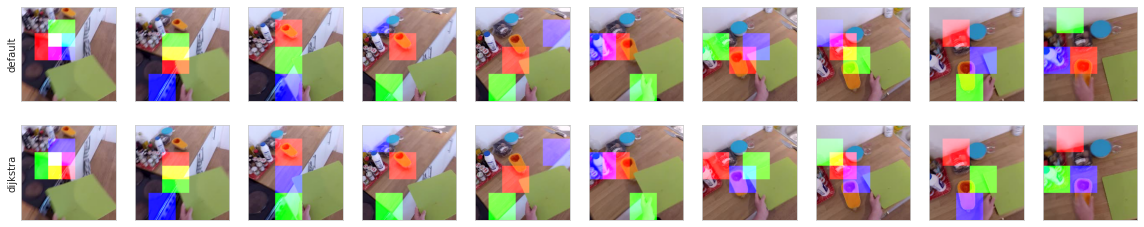

In [6]:
reorder_dijkstra(bboxes[0], rgb)

## Variant bbox size

In [7]:
spatial_sampler = model.spatial_sampler  # Default sampler

spatial_sampler.min_b_size = 64
spatial_sampler.max_b_size = 112

opts = {'reorder_vid':True, 'avg_across_time':True}

bboxes, rgb = experiment(sample_id, spatial_sampler, **opts)
reorder_dijkstra(bboxes[0], rgb)

RuntimeError: Sizes of tensors must match except in dimension 2. Got 92 and 110

## Variant bbox size + don't average bbox across time

In [ ]:
spatial_sampler = model.spatial_sampler  # Default sampler

spatial_sampler.min_b_size = 64
spatial_sampler.max_b_size = 112

opts = {'reorder':True, 'avg_across_time':False}

bboxes, rgb = experiment(sample_id, spatial_sampler, **opts)
reorder_dijkstra(bboxes[0], rgb)

## Variant bbox size + don't average bbox across time + don't reorder by position

In [ ]:
spatial_sampler = model.spatial_sampler  # Default sampler

spatial_sampler.min_b_size = 64
spatial_sampler.max_b_size = 112

opts = {'reorder':False, 'avg_across_time':False}

bboxes, rgb = experiment(sample_id, spatial_sampler, **opts)
reorder_dijkstra(bboxes[0], rgb)

<hr style="height:30px; background-color:#123456;"/>

## NMS

In [ ]:
from src.models.space_sampler_nms import SpatialSamplerNMS

spatial_sampler = SpatialSamplerNMS(top_k=3, min_b_size=64, max_b_size=64,
                                    steps=7, iou_thres=0.3, area_limit=0.25)
opts = {'reorder':True, 'avg_across_time':True}

bboxes, rgb = experiment(sample_id, spatial_sampler, **opts)
reorder_dijkstra(bboxes[0], rgb)

## NMS + variant bbox size

In [ ]:
spatial_sampler = SpatialSamplerNMS(top_k=3, min_b_size=64, max_b_size=112,
                                    steps=7, iou_thres=0.3, area_limit=0.25)
opts = {'reorder':True, 'avg_across_time':True}

bboxes, rgb = experiment(sample_id, spatial_sampler, **opts)
reorder_dijkstra(bboxes[0], rgb)

## NMS + variant bbox size + don't average bbox across time

In [ ]:
spatial_sampler = SpatialSamplerNMS(top_k=3, min_b_size=64, max_b_size=112,
                                    steps=7, iou_thres=0.3, area_limit=0.25)
opts = {'reorder':True, 'avg_across_time':False}

bboxes, rgb = experiment(sample_id, spatial_sampler, **opts)
reorder_dijkstra(bboxes[0], rgb)
print('aaa')

## NMS + variant bbox size + don't average bbox across time + don't reorder

In [ ]:
spatial_sampler = SpatialSamplerNMS(top_k=3, min_b_size=64, max_b_size=112,
                                    steps=7, iou_thres=0.3, area_limit=0.25)
opts = {'reorder':False, 'avg_across_time':False}

bboxes, rgb = experiment(sample_id, spatial_sampler, **opts)
reorder_dijkstra(bboxes[0], rgb)

In [ ]:
# tid = 0
# _attn = attn[tid].mean(dim=0).cpu().detach().numpy()
# _rgb = MiscUtils.deprocess_rgb(sample['RGB'][0], 10)[tid]
# print(_attn.shape)

# fig, axes = plt.subplots(1, 2)
# axes[0].imshow(_rgb)
# axes[1].imshow(_attn)


# # thres_lst = np.linspace(_attn.min(), _attn.max(), 9)
# thres_lst = _attn.mean() + np.linspace(-_attn.std(), _attn.std(), 7)
# print(thres_lst)
# print(_attn.mean(), _attn.std())
# # print(_attn.mean() + 0.3*_attn.std())

# props = []
# for thres in thres_lst:
#     mask = np.where(_attn > thres, 1.0, 0.0)
#     segments, n_seg = measure.label(mask, return_num=True)
#     props += [x for x in measure.regionprops(segments)
#               if len(x.coords) < 0.25*np.prod(_attn.shape)]

# #     plt.figure(); plt.imshow(segments)
    
# bboxes = [x.bbox for x in props]
# scores = [(_attn[x.coords[:,0], x.coords[:,1]]).sum() for x in props]
# # scores = [(_attn[x.coords[:,0], x.coords[:,1]]).mean() for x in props]

# from torchvision.ops import nms
# ans = nms(torch.tensor(bboxes, dtype=torch.float32), torch.tensor(scores, dtype=torch.float32), 0.3)
# print(scores)
# print(ans.numpy())

# # for i in ans.numpy():
# #     plt.figure(); plt.imshow(props[i].image)
# #     print(props[i].bbox)

# fig, axes = plt.subplots(2, len(ans), figsize=(15, 5))
# scale = 224/7
# for i in range(len(ans)):
#     foo = props[ans[i]]
#     axes[0, i].imshow(foo.image, vmin=0, vmax=1)
#     bbox2 = (np.array(foo.bbox) * scale).astype(int)
#     print(bbox2)
#     axes[1, i].imshow(_rgb[bbox2[0]:bbox2[2], bbox2[1]:bbox2[3]])